# Predict Future Sale - Baseline
## Final project for "How to win a data science competition" Coursera course
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data  
>Student: Rafael Caneiro de Oliveira  
>Email: rafael.caneiro@gmail.com  
>Date: 04/08/2020

## Load

In [8]:
import numpy as np
import pandas as pd
from itertools import product

from pathlib import Path

PATH = Path.cwd().parent
DATA_PATH = Path(PATH, "./data/raw/") 
MODEL_PATH = Path(PATH, "./models/") 

In [9]:
sales = pd.read_csv(Path(DATA_PATH,"sales_train.csv"))
items = pd.read_csv(Path(DATA_PATH,"items.csv"))
categories = pd.read_csv(Path(DATA_PATH,"item_categories.csv"))
shops = pd.read_csv(Path(DATA_PATH,"shops.csv"))
test = pd.read_csv(Path(DATA_PATH,"test.csv"))
test["date_block_num"]=34

## Aggregate

In [10]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})

#fix column names
gb.rename({"item_cnt_day":"target"}, inplace=True, axis=1)

#join aggregated data to the grid
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

## Join

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [12]:
train = train.merge(items, on="item_id", how="left")
train = train.merge(categories, on="item_category_id", how="left")
train = train.merge(shops, on="shop_id", how="left")
train.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
train = reduce_mem_usage(train)
train.head() 

Memory usage after optimization is: 156.12 MB
Decreased by 58.3%


,shop_id,item_id,date_block_num,target,item_category_id
0,0,19,0,0.0,40
1,0,27,0,0.0,19
2,0,28,0,0.0,30
3,0,29,0,0.0,23
4,0,32,0,6.0,40


In [13]:
test = test.merge(items, on="item_id", how="left")
test = test.merge(categories, on="item_category_id", how="left")
test = test.merge(shops, on="shop_id", how="left")
test.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
test = reduce_mem_usage(test)
test.head()

Memory usage after optimization is: 3.47 MB
Decreased by 64.6%


,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


## Test / Validation Split

In [14]:
def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2013-oct
train_1 = get_index(0, 10, train, "date_block_num")

# 2013-nov
val_1 = get_index(10, 10, train, "date_block_num")

# 2014-jan >> 2014-oct
train_2 = get_index(12, 22, train, "date_block_num")

# 2014-nov
val_2 = get_index(22, 22, train, "date_block_num")

# 2015-jan >> 2015-sep
train_3 = get_index(24, 33, train, "date_block_num")

# 2015-oct
val_3 = get_index(33, 33, train, "date_block_num")

# 2013-jan >> 2015-sep
train_all = get_index(0, 33, train, "date_block_num")

folds = [(train_1, val_1), (train_2, val_2), (train_3, val_3)]

## Features / Target

In [15]:
remove_cols = ["target", "item_name", "item_category_name", "shop_name"]
features = [col for col in train.columns if col not in remove_cols]
target="target"

## General Approach for Parameter Tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
4. Lower the learning rate and decide the optimal parameters .

### Step 1 - 

In [ ]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=1, verbosity=1)

## Grid Search

In [17]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {"learning_rate":[0.03, 0.1, 0.3, 1],
              "min_child_weight":[1, 3, 10],
              "max_depth":[3, 10, 30],
              "gamma":[0, 0.1, 0.3, 1],
              "subsample":[0.1, 0.3, 1],
              "colsample_bytree":[0.1, 0.3, 1],
              "n_estimators":[10, 30, 100]}

# X_eval = train.loc[val_3, features]
# y_eval = train.loc[val_3, target]

# fit_params={"early_stopping_rounds":10, 
#             "eval_metric" : "rmse", 
#             "eval_set" : [[X_eval, y_eval]]}

rs = RandomizedSearchCV(estimator=xgb,
                        param_distributions=parameters,
                        n_iter=48,
                        scoring="neg_mean_squared_error",
                        cv=folds,
                        verbose=2,
                        n_jobs=24,
                        pre_dispatch=24,
                        random_state=42)

# search = rs.fit(X=train[features], y=train[target])

In [18]:
# search.best_params_

# {'subsample': 1,
#  'n_estimators': 30,
#  'min_child_weight': 10,
#  'max_depth': 30,
#  'learning_rate': 0.1,
#  'gamma': 0.3,
#  'colsample_bytree': 1}

## Learning Curve

In [19]:
# xgb = XGBRegressor(tree_method="exact",
#                    objective="reg:squarederror",
#                    subsample=1,
#                    n_estimators=100,
#                    min_child_weight=10,
#                    max_depth=30,
#                    learning_rate=0.1,
#                    gamma=0.3,
#                    colsample_bytree=1,
#                    random_state=42, 
#                    n_jobs=24,
#                    verbosity=1)

xgb = XGBRegressor(tree_method="exact",
                   objective="reg:squarederror",
                   subsample=1,
                   n_estimators=3000,
                   min_child_weight=10,
                   max_depth=10,
                   learning_rate=0.3,
                   gamma=0.3,
                   colsample_bytree=1,
                   random_state=42, 
                   n_jobs=24,
                   verbosity=1)

In [20]:
X_train = train.loc[train_all, features]
y_train = train.loc[train_all, target]
X_eval = train.loc[val_3, features]
y_eval = train.loc[val_3, target]
eval_set = [(X_train, y_train), (X_eval, y_eval)]

In [24]:
model = None
# model = xgb.fit(X_train, y_train,
#                 eval_set=eval_set,
#                 eval_metric="rmse",
#                 verbose=True)

In [25]:
model_name = "Model_XGBoost_Tuned_3000_estimators"

from joblib import dump, load
if model is not None:
    dump(model, Path(MODEL_PATH, model_filename+".joblib"))
else:
    model = load(Path(MODEL_PATH, model_name+".joblib"))
    

In [26]:
print("train final score", model.evals_result_["validation_0"]["rmse"][-1:])

train final score [0.922471]


In [27]:
print("val final score", model.evals_result_["validation_1"]["rmse"][-1:])

val final score [0.922306]


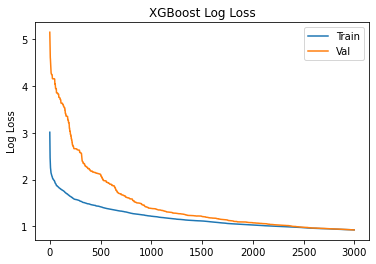

In [28]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

## Predictions

In [29]:
pred = pred_model.predict(test[features])
pred = np.clip(pred, 0, 20)

## Submission

In [31]:
submission = pd.DataFrame({"ID":range(pred.shape[0]),
                           "item_cnt_month":pred})

sub_file_name = "submission_"+model_name+".csv"

submission[["ID", "item_cnt_month"]].to_csv(Path(MODEL_PATH, sub_file_name),
                                            index=False)

!kaggle competitions submit -c competitive-data-science-predict-future-sales -f $sub_file_name -m "Model_XGBoost_Tuned_3000_estimators"

/bin/bash: kaggle: command not found
